In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

import matplotlib.pyplot as plt

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils.data import DataLoader, Dataset

from matplotlib import pyplot as plt

from xml.etree import ElementTree as et

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load your model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
model.load_state_dict(torch.load("fasterrcnn_ap85.pth", map_location=device))

d:\anaconda\envs\torchgpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\envs\torchgpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [3]:
# Move the model to the appropriate device
model = model.to(device)

In [4]:
def predict(images):
    model.eval()
    images = list(image.to(device) for image in images)
    outputs = model(images)
    return outputs

In [5]:
files_dir = 'data/newdata/test'
img_name = 'DJI_0810_JPG_jpg.rf.da9c6093b772c827c161bd924bc923b7.jpg'
imagepath = image_path = os.path.join(files_dir, img_name)
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
img_res = cv2.resize(img_rgb, (1024, 1024), cv2.INTER_AREA)
img_res /= 255.0

In [6]:
def draw_boxes_on_image(boxes, images):
    sample = images[0].permute(1, 2, 0).cpu().numpy().copy()

    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.set_axis_off()
    ax.imshow(sample)
    print(f"Tassel count: {len(boxes)}")
    plt.show()

In [7]:
output = predict([torch.tensor(img_res, dtype=torch.float32).permute(2, 0, 1).to(device)])
detection_threshold = 0.6
prediction_boxes = output[0]['boxes'].data.cpu().numpy()
scores = output[0]['scores'].data.cpu().numpy()

prediction_boxes = prediction_boxes[scores >= detection_threshold].astype(np.int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PREDICTED OUTPUT

Tassel count: 1


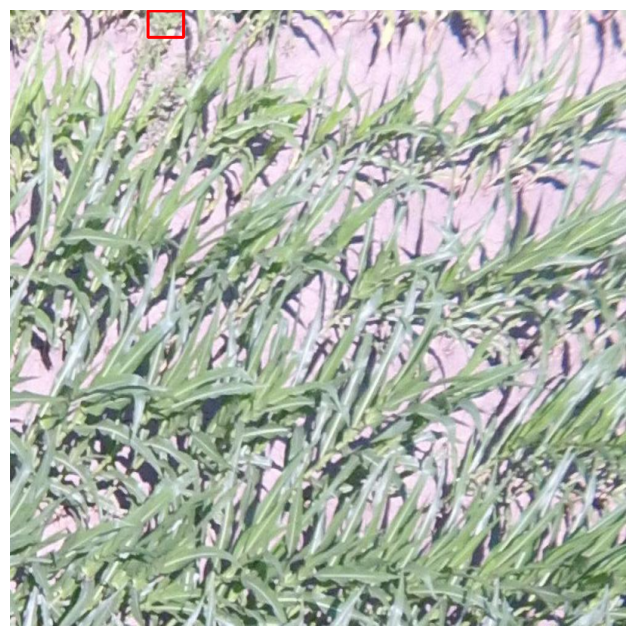

In [8]:
print("PREDICTED OUTPUT\n")
draw_boxes_on_image(prediction_boxes, [torch.tensor(img_res, dtype=torch.float32).permute(2, 0, 1).to(device)])